Predicción de carga de trabajo semanal en consultoría
Este proyecto tiene por objetivo desarrollar un modelo de Machine Learning capaz de anticipar las horas de trabajo semanales requeridas por los equipos de consultoría, de modo que la dirección de proyectos pueda planificar con antelación la asignación de recursos, evitar sobrecargas y optimizar la rentabilidad.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Para Prophet (si se usa)
!pip install prophet
from prophet import Prophet

# Visualización
import plotly.express as px

# Fecha
from datetime import timedelta

In [ ]:
ruta_archivo = r'/content/horas_ns_modified.csv'

df = pd.read_csv(ruta_archivo, encoding='latin1')
print(df.head())


  Year_Week  PROYECTOS  CONSULTORES  HORAS  Column5  Week_Start  Month  \
0   2019_36         31           12    475     25.0  09/09/2019      9   
1   2019_37         30           14    551     42.0  16/09/2019      9   
2   2019_38         37           15    577     95.0  23/09/2019      9   
3   2019_39         32           15    599     41.0  30/09/2019      9   
4   2019_40         43           15    550     38.0  07/10/2019     10   

   Quarter  Holiday_Flag Client_Industry             Project_Type  \
0        3             0           Salud  Consultoría estratégica   
1        3             1           Salud           Implementación   
2        3             0         Energía  Consultoría estratégica   
3        3             0           Salud           Implementación   
4        4             0         Energía            Mantenimiento   

   Planned_Hours  Budget_Hours  Economic_Index  
0          479.6         487.9          101.05  
1          556.4         663.0          10

In [ ]:
# Convertir Year_Week a fecha (lunes)
df['Week_Start'] = pd.to_datetime(df['Year_Week'] + '-1', format='%Y_%W-%w')

# Ordenar por fecha
df = df.sort_values('Week_Start').reset_index(drop=True)

# Ver info inicial
df.head()

,Year_Week,PROYECTOS,CONSULTORES,HORAS,Column5,Week_Start,Month,Quarter,Holiday_Flag,Client_Industry,Project_Type,Planned_Hours,Budget_Hours,Economic_Index
0,2019_36,31,12,475,25.0,2019-09-09,9,3,0,Salud,Consultoría estratégica,479.6,487.9,101.05
1,2019_37,30,14,551,42.0,2019-09-16,9,3,1,Salud,Implementación,556.4,663.0,104.40
2,2019_38,37,15,577,95.0,2019-09-23,9,3,0,Energía,Consultoría estratégica,542.6,624.9,107.38
3,2019_39,32,15,599,41.0,2019-09-30,9,3,0,Salud,Implementación,621.1,700.5,107.62
4,2019_40,43,15,550,38.0,2019-10-07,10,4,0,Energía,Mantenimiento,504.7,581.3,101.86


In [ ]:
# Variables categóricas
categorical = ['Client_Industry', 'Project_Type']
df = pd.get_dummies(df, columns=categorical)

# Rellenar posibles NaN (por seguridad)
df = df.fillna(0)

In [ ]:
# Crear lags para la variable objetivo
for lag in [1, 2, 3, 4]:
    df[f'HORAS_lag{lag}'] = df['HORAS'].shift(lag)

# Ventanas móviles
df['HORAS_roll_mean4'] = df['HORAS'].rolling(window=4).mean()
df['HORAS_roll_std4'] = df['HORAS'].rolling(window=4).std()

# Eliminar nulos generados por los lags
df = df.dropna().reset_index(drop=True)


In [ ]:
# Ratios de eficiencia
df['Ratio_Ejecucion'] = df['HORAS'] / df['Planned_Hours']
df['Ratio_Presupuesto'] = df['HORAS'] / df['Budget_Hours']

# Selección de columnas
features = [
    'Month', 'Quarter', 'Holiday_Flag', 'Planned_Hours', 'Budget_Hours',
    'Economic_Index', 'Ratio_Ejecucion', 'Ratio_Presupuesto',
    'HORAS_lag1', 'HORAS_lag2', 'HORAS_lag3', 'HORAS_lag4',
    'HORAS_roll_mean4', 'HORAS_roll_std4'
] + [col for col in df.columns if 'Client_Industry_' in col or 'Project_Type_' in col]

target = 'HORAS'


In [ ]:
# Juntar X_train y y_train en un DataFrame temporal
df_train_temp = pd.concat([X_train, y_train], axis=1)

# Eliminar filas con NaN
df_train_temp = df_train_temp.dropna()

# Separar nuevamente
X_train = df_train_temp[features]
y_train = df_train_temp[target]


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar el modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predecir en el conjunto de test
y_pred_rf = rf.predict(X_test)

# Evaluar ambos modelos
evaluar_modelo("Regresión Lineal", y_test, y_pred_lr)
evaluar_modelo("Random Forest", y_test, y_pred_rf)

# Visualización
df_pred = test.copy()
df_pred['Pred_LR'] = y_pred_lr
df_pred['Pred_RF'] = y_pred_rf

df_pred_plot = df_pred[['Week_Start', 'HORAS', 'Pred_LR', 'Pred_RF']].melt(id_vars='Week_Start')
fig = px.line(df_pred_plot, x='Week_Start', y='value', color='variable', title='Predicción vs Real')
fig.show()


🔎 Regresión Lineal
MAE: 5.371703082346357e-13
RMSE: 6.24566660556242e-13
------------------------------
🔎 Random Forest
MAE: 22.656000000000002
RMSE: 28.70967467596943
------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kkv5arp/lpjxkcah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kkv5arp/9kooh8v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84433', 'data', 'file=/tmp/tmp7kkv5arp/lpjxkcah.json', 'init=/tmp/tmp7kkv5arp/9kooh8v3.json', 'output', 'file=/tmp/tmp7kkv5arp/prophet_model2r7tawfa/prophet_model-20250701073220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


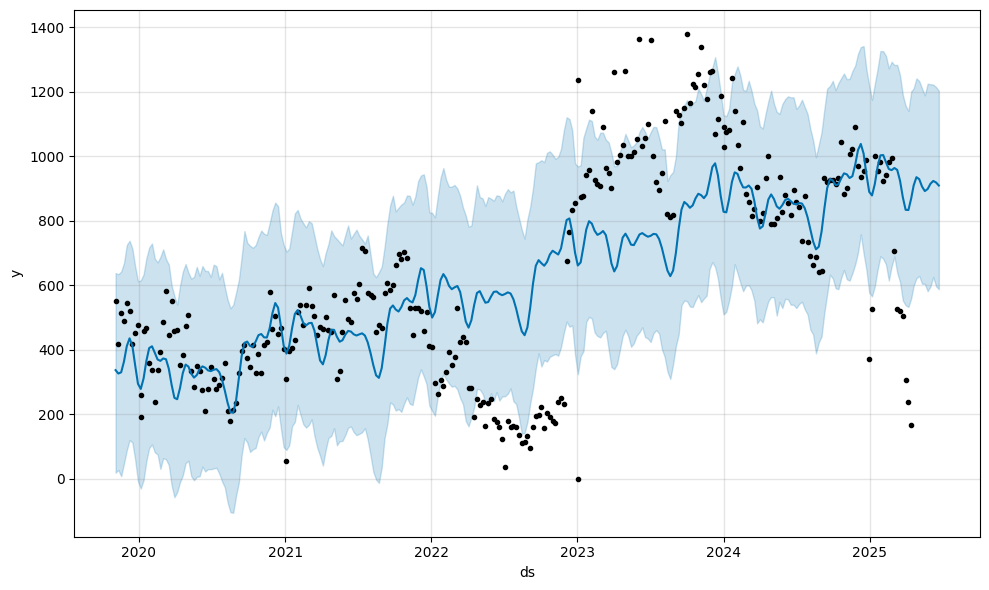

In [ ]:
# Preparar datos para Prophet
df_prophet = df[['Week_Start', 'HORAS']].rename(columns={'Week_Start': 'ds', 'HORAS': 'y'})

# Entrenar Prophet
model = Prophet()
model.fit(df_prophet)

# Crear dataframe futuro
future = model.make_future_dataframe(periods=10, freq='W')
forecast = model.predict(future)

# Mostrar forecast
fig2 = model.plot(forecast)

In [ ]:
import joblib
from google.colab import files  # ✅ Importar módulo necesario

# Guardar el modelo
joblib.dump(rf, "modelo_random_forest.pkl")

# Descargar el archivo
files.download("modelo_random_forest.pkl")

df_pred_export = df_pred[['Week_Start', 'HORAS', 'Pred_RF']]
df_pred_export.to_csv("predicciones_rf.csv", index=False)
files.download("predicciones_rf.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>